In [367]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [338]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
#for sql
import sqlite3
from sqlite3 import Error
#for git
import subprocess

In [339]:
connection = sqlite3.connect('covid_db.db', timeout=10, isolation_level = None)

In [340]:
process = subprocess.Popen(["git", '-C', '/"NYT repo"/covid-19-data', "pull"], stdout=subprocess.PIPE)
output = process.communicate()[0]
output

b''

In [341]:
file2 = 'NYT Repo/covid-19-data/us-states.csv'
df = pd.read_csv(file2)

df = df[['date', 'state', 'cases', 'deaths']]

#find max/min date in dataset
mx_date = df['date'].max().split('-')
mn_date = df['date'].min().split('-')

diff = (dt.date(int(mx_date[0]), int(mx_date[1]), int(mx_date[2]))
            - dt.date(int(mn_date[0]), int(mn_date[1]), int(mn_date[2])))

first_week = int((diff.days - diff.days%7)/7)

#create list to perform rolling week comparison
strptime = []
for x in df['date']:
    this_date = x.split('-')
    diff = (dt.date(int(mx_date[0]), int(mx_date[1]), int(mx_date[2]))
            - dt.date(int(this_date[0]), int(this_date[1]), int(this_date[2])))
    
    this_week = int((diff.days - diff.days%7)/7)
    
    strptime.append(first_week - this_week)
    #strptime.append('CurrDiff '+str(int((diff.days - diff.days%7)/7)))

df['rollwk'] = strptime

ca_df = df.loc[df['state']=='California']
# df2.loc[df2['state']=='California']
ca_df['new_deaths'] = ca_df['deaths'] - ca_df['deaths'].shift(1)
ca_df['new_cases'] = ca_df['cases'] - ca_df['cases'].shift(1)

ca_df = ca_df.groupby(['rollwk']).sum().reset_index()
#df

C:\Users\kyled\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\kyled\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [342]:
df

,date,state,cases,deaths,rollwk
0,2020-01-21,Washington,1,0,0
1,2020-01-22,Washington,1,0,0
2,2020-01-23,Washington,1,0,0
3,2020-01-24,Illinois,1,0,0
4,2020-01-24,Washington,1,0,0
...,...,...,...,...,...
8369,2020-08-01,Virginia,90801,2215,27
8370,2020-08-01,Washington,59647,1676,27
8371,2020-08-01,West Virginia,6735,116,27
8372,2020-08-01,Wisconsin,58064,955,27


Text(0.5, 1.0, 'Coronavirus deaths in CA, rolling week total')

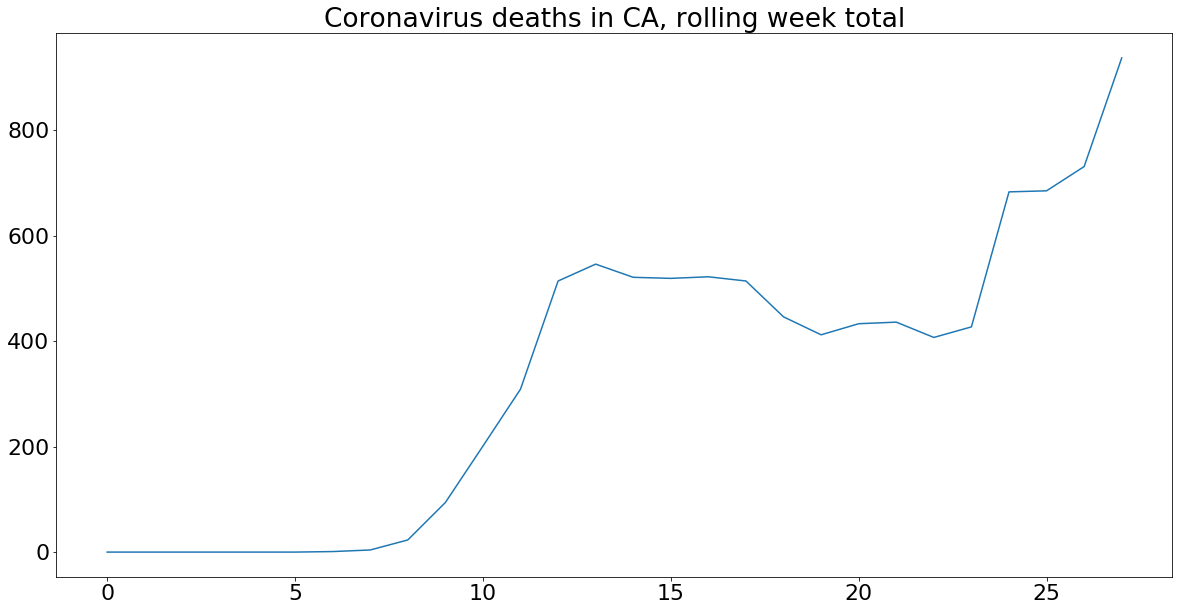

In [343]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize = (20, 10))
plt.plot(ca_df['rollwk'], ca_df['new_deaths'])
plt.title('Coronavirus deaths in CA, rolling week total')

Text(0.5, 1.0, 'Coronavirus cases in CA, rolling week total')

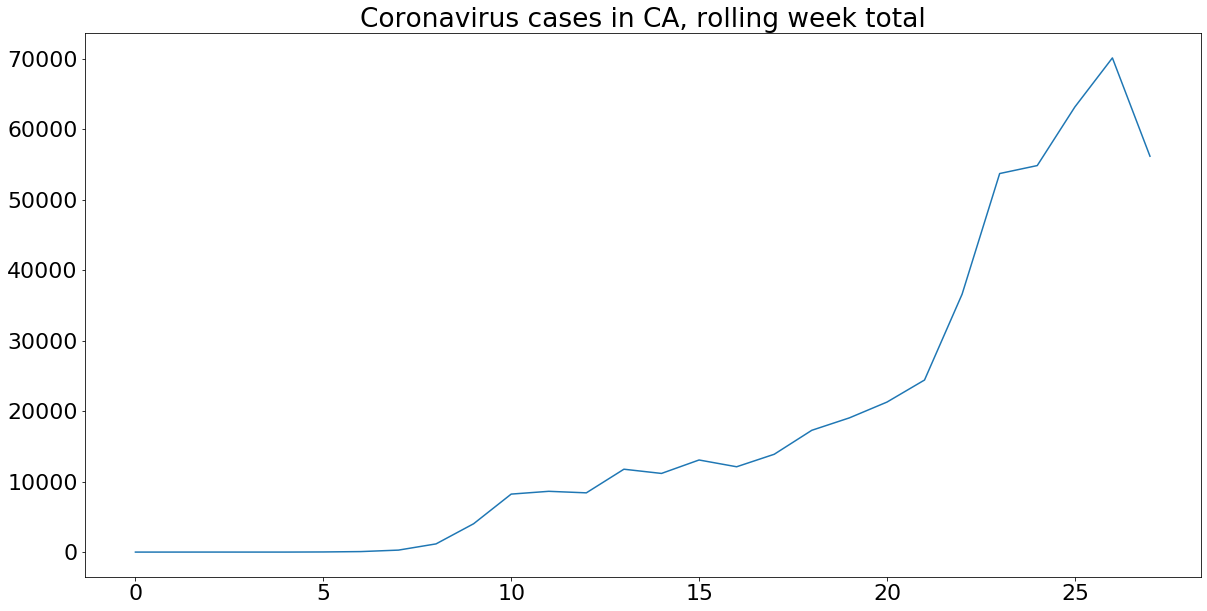

In [344]:
plt.figure(figsize = (20, 10))
plt.plot(ca_df['rollwk'], ca_df['new_cases'])
plt.title('Coronavirus cases in CA, rolling week total')

In [363]:
file = 'Resources\population.csv'
pop = pd.read_csv(file)
# pop[['STATE', 'NAME', 'POPESTIMATE2019']]
# pop.columns.to_list()

In [346]:
cur = connection.cursor()
connection.commit()
cur.execute('drop table if exists population;')
connection.commit()

sql = """
create table population
(id int not null
,name varchar(25) not null
,pop int
--,primary key clustered index (id, name)
);
"""

cur.execute(sql)
connection.commit()

sql_list = []

for i in pop.index:
    sql_list.append(pop.iloc[i].to_list())

for entry in sql_list:
    format_str = """insert into population (id, name, pop)
    values ("{id}", lower("{name}"), "{pop}");"""
    
    sql = format_str.format(id=entry[3]
                            , name=entry[4]
                            , pop=entry[16]
                           )
    if id != '0':
        cur.execute(sql)

# cur.execute(sql)
connection.commit()
cur.execute('select * from population')
results = cur.fetchall()
connection.commit()
# print(results)
#cur.close()

In [347]:
cur = connection.cursor()
connection.commit()
cur.execute('drop table if exists covid;')
connection.commit()

sql = """
create table covid
(date varchar(10) not null
,state varchar(25) not null
,rollwk int not null
,cases decimal(20, 6)
,deaths decimal(20, 6)
--,primary key clustered index (date, state, rollwk)
);
"""

cur.execute(sql)
connection.commit()

sql_list = []

for i in df.index:
    sql_list.append(df.iloc[i].to_list())

for entry in sql_list:
    format_str = """insert into covid (date, state, cases, deaths, rollwk)
    values ("{date}", "{state}", "{cases}", "{deaths}", "{rollwk}");"""
    
    sql = format_str.format(date=entry[0]
                            , state=entry[1]
                            , cases=entry[2]
                            , deaths=entry[3]
                            , rollwk=entry[4])
    cur.execute(sql)

cur.execute(sql)
connection.commit()
cur.execute('select * from covid')
results = cur.fetchall()
connection.commit()
#print(results)
#cur.close()

In [348]:
cur = connection.cursor()
connection.commit()
cur.execute('PRAGMA table_info(covid);')
test = pd.DataFrame(cur.fetchall())
# print(cur.fetchall())
connection.commit()
test[1].to_list()

['date', 'state', 'rollwk', 'cases', 'deaths']

In [349]:
sql = """select 
    rollwk
    , cast(state as varchar(25)) as locale
    , sum(lag_cases) as new_cases
    , sum(lag_deaths) as new_deaths
from
(select *, deaths - lag(deaths, 1) over (partition by state
                                         order by date) as lag_deaths
         , cases - lag(cases, 1) over (partition by state
                                       order by date) as lag_cases
from covid c
) lagged
group by state, rollwk

union

select
    rollwk
    , 'Nationwide' as locale
    , sum(lag_cases) as new_cases
    , sum(lag_deaths) as new_deaths
from
(select *, deaths - lag(deaths, 1) over (partition by state
                                         order by date) as lag_deaths
         , cases - lag(cases, 1) over (partition by state
                                       order by date) as lag_cases
from covid c
) lagged
group by rollwk;
"""

cur.execute(sql)
results = cur.fetchall()
cur.close()
#print(results)

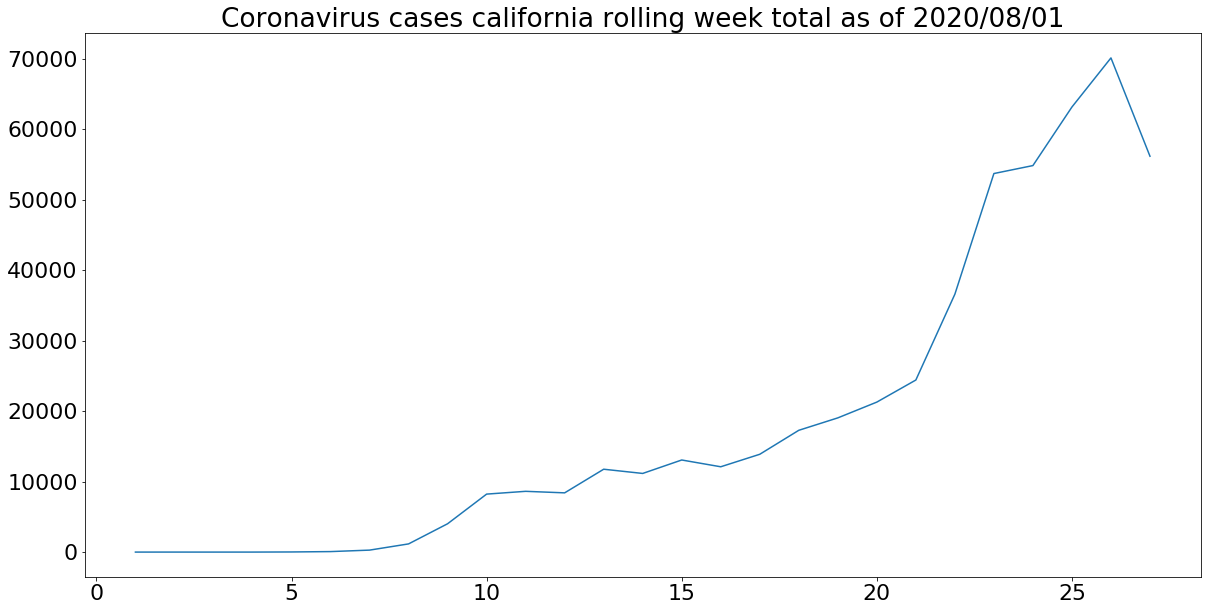

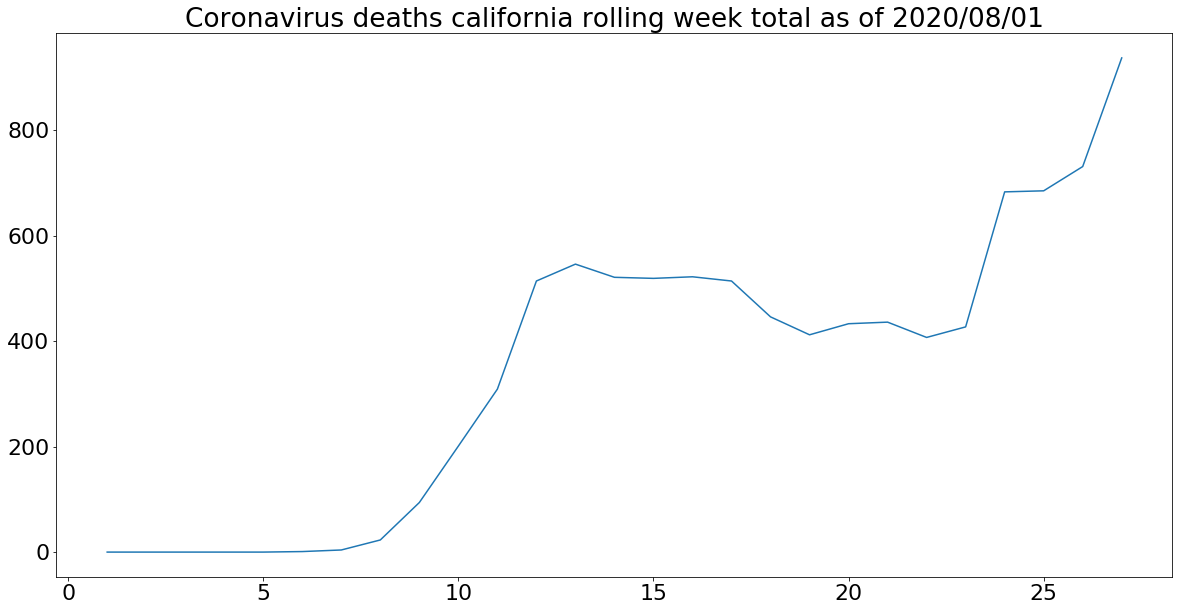

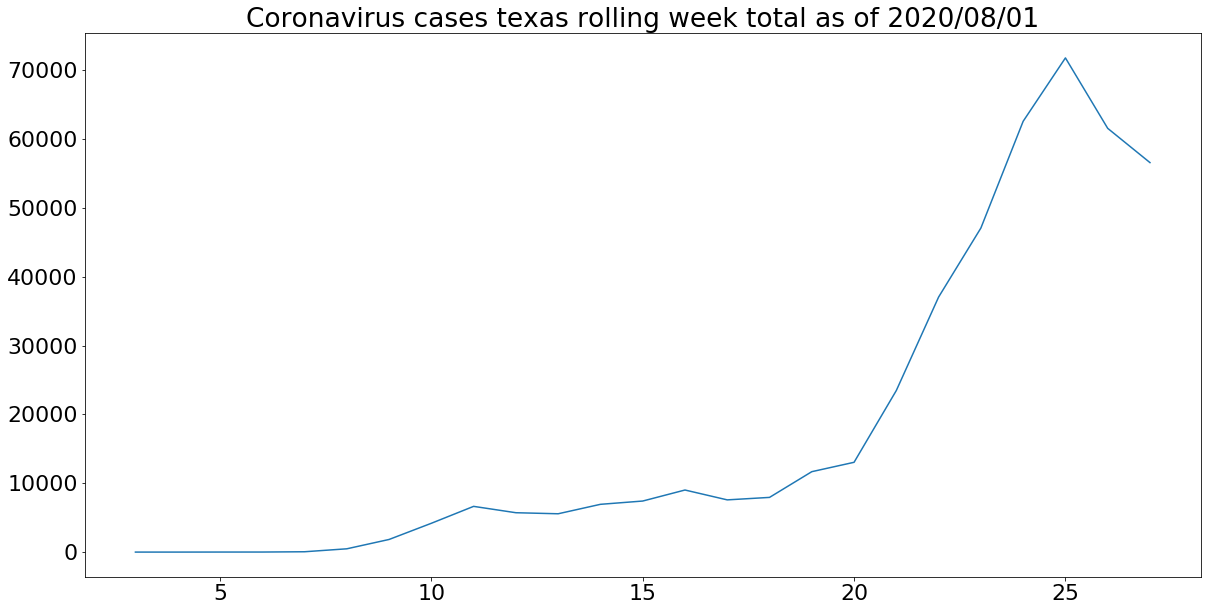

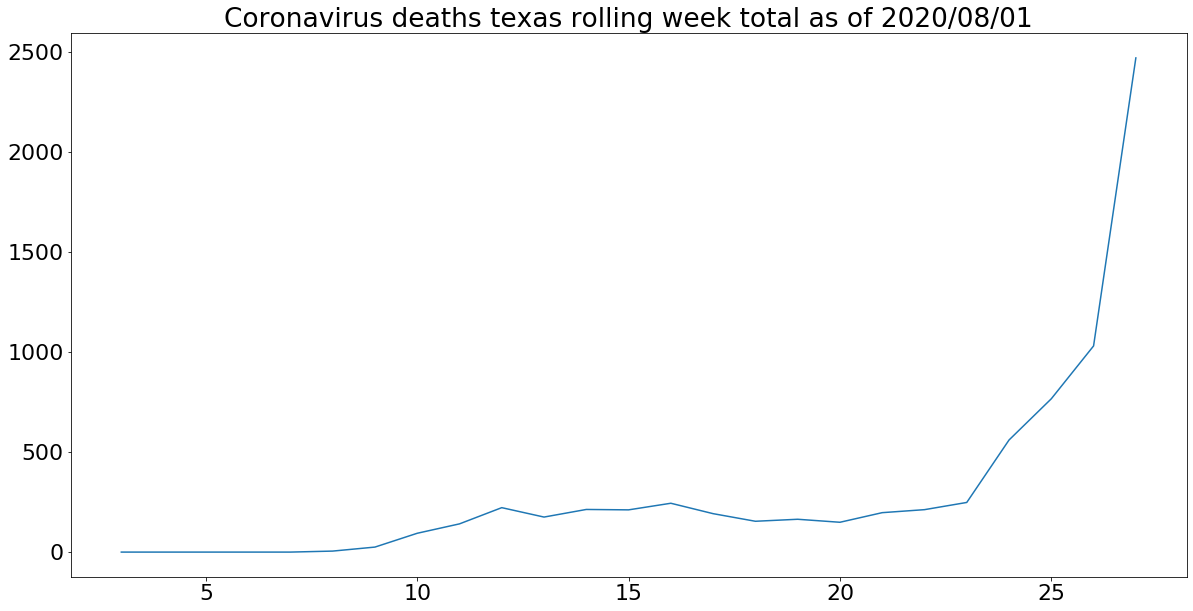

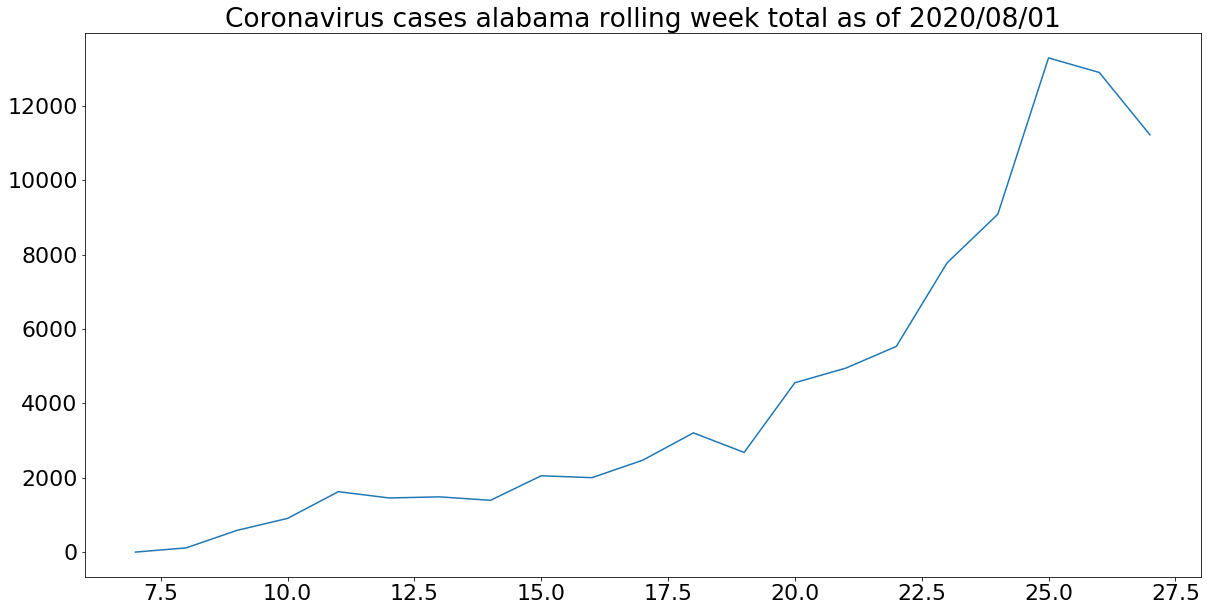

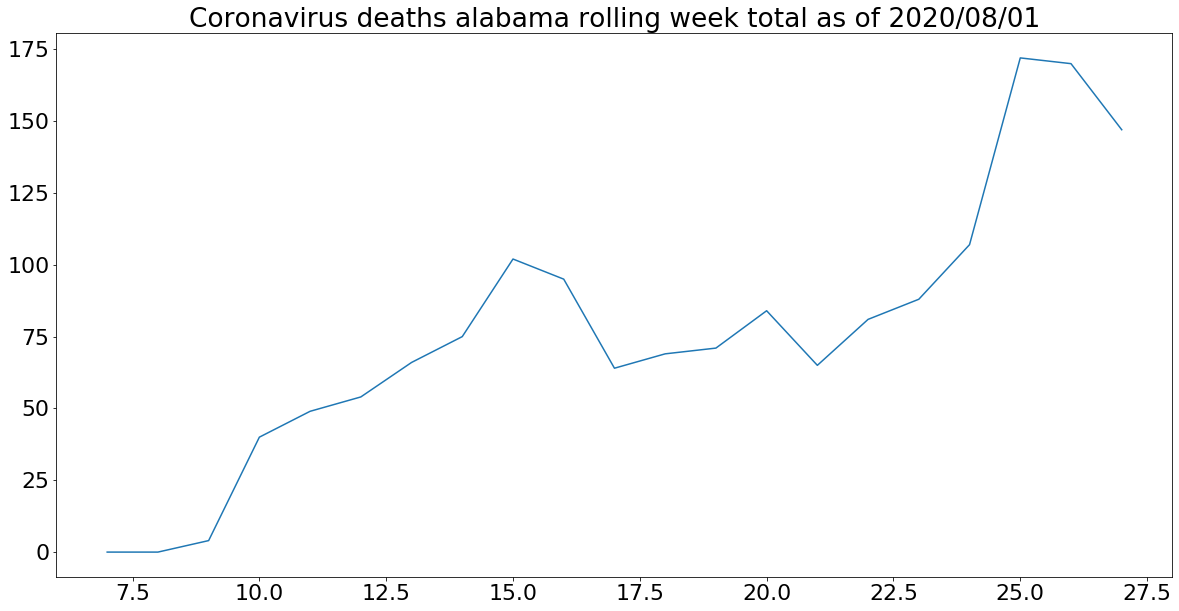

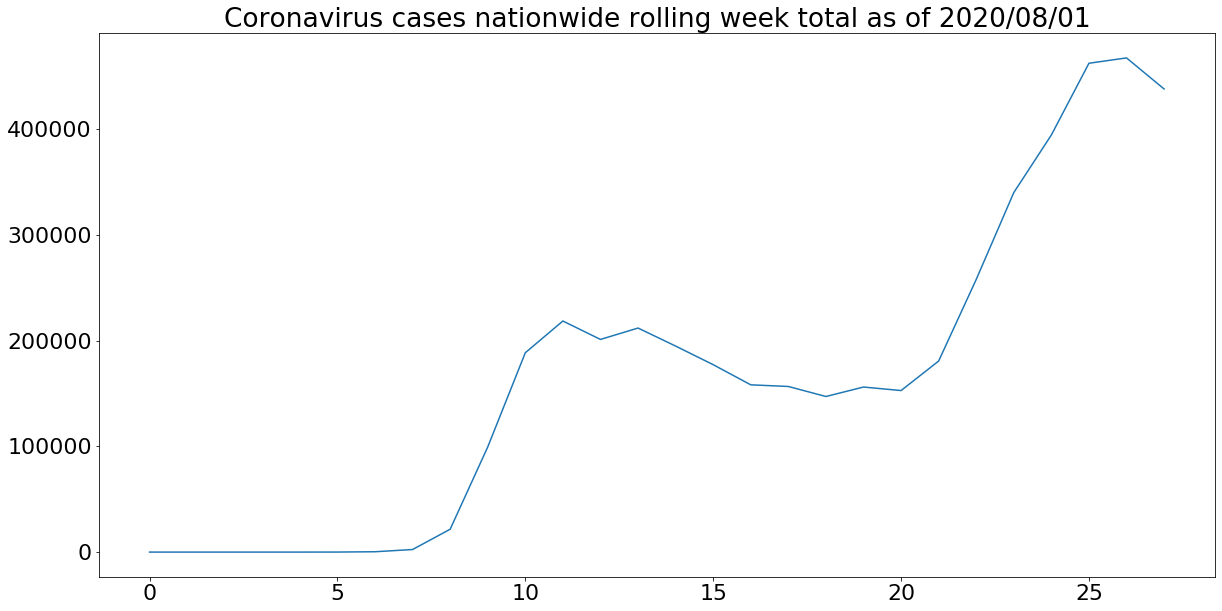

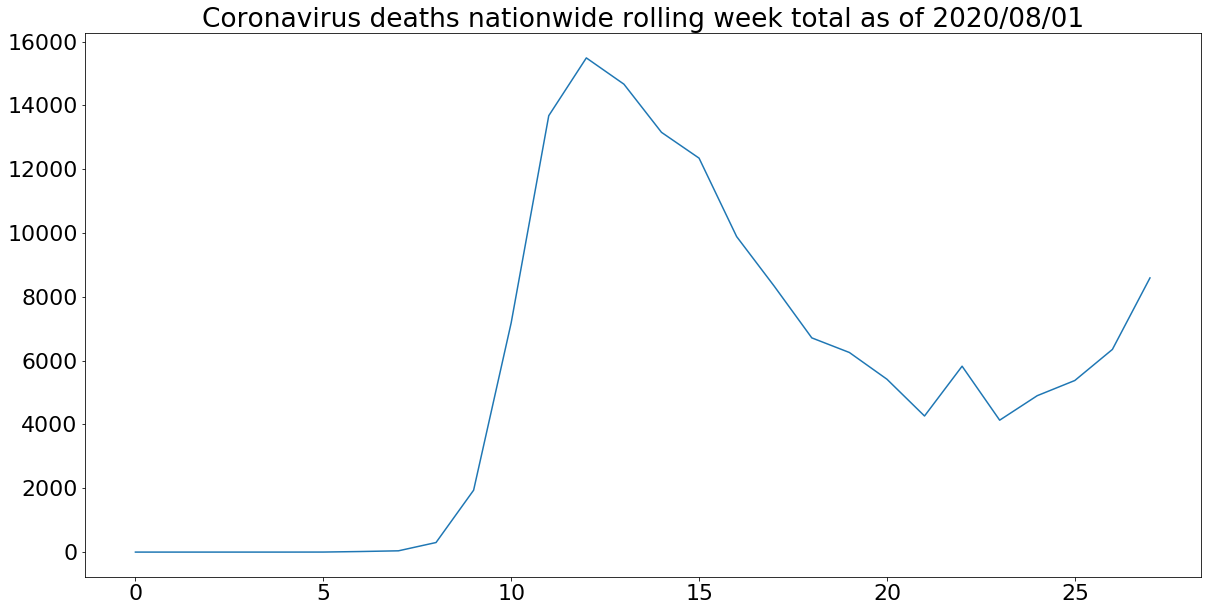

In [350]:
# print('Which state would you like to view data for? Or type "Nationwide" for nationwide stats.')
# locale = input()
for locale in ['california', 'texas', 'alabama', 'nationwide']:
    for disp in ['cases', 'deaths']:
#     locale = 'nationwide'
#     display = 'cases'

        df3 = pd.DataFrame(results)
        df3.columns = ['rollwk', 'state', 'new_cases', 'new_deaths']
        df3['state'] = df3['state'].str.lower()
        df3 = df3.loc[df3['state']==f'{locale}']

        plt.rcParams.update({'font.size': 22})
        plt.figure(figsize = (20, 10))
        plt.plot(df3['rollwk'], df3[f'new_{disp}'])
        plt.title(f'Coronavirus {disp} {locale} rolling week total as of '
                  +f'{mx_date[0]}/'+f'{mx_date[1]}/'+f'{mx_date[2]}')

        #if new week, save image
        diff = (dt.date(int(mx_date[0]), int(mx_date[1]), int(mx_date[2]))
                    - dt.date(int(mn_date[0]), int(mn_date[1]), int(mn_date[2])))

        if diff.days%7 == 0:
            plt.savefig(f'charts/covid_'+f'{locale}'+'_'+f'{disp}'+'_'+f'{mx_date[0]}'+f'{mx_date[1]}'+f'{mx_date[2]}'+'.png')

In [351]:
df

,date,state,cases,deaths,rollwk
0,2020-01-21,Washington,1,0,0
1,2020-01-22,Washington,1,0,0
2,2020-01-23,Washington,1,0,0
3,2020-01-24,Illinois,1,0,0
4,2020-01-24,Washington,1,0,0
...,...,...,...,...,...
8369,2020-08-01,Virginia,90801,2215,27
8370,2020-08-01,Washington,59647,1676,27
8371,2020-08-01,West Virginia,6735,116,27
8372,2020-08-01,Wisconsin,58064,955,27


In [352]:
diff = (dt.date(int(mx_date[0]), int(mx_date[1]), int(mx_date[2]))
            - dt.date(int(mn_date[0]), int(mn_date[1]), int(mn_date[2])))

diff.days%7

4

In [353]:
pop.head()

,SUMLEV,REGION,DIVISION,STATE,NAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,10,0,0,0,United States,308745538,308758105,309321666,311556874,313830990,...,0.000000,2.493773,2.682083,2.636187,2.921500,3.260435,3.252788,2.871957,2.153911,1.818059
1,20,1,0,0,Northeast Region,55317240,55318443,55380134,55604223,55775216,...,-5.254530,0.887909,-0.038355,-0.469783,-0.986097,-2.061965,-2.490484,-1.837048,-2.134447,-2.859713
2,20,2,0,0,Midwest Region,66927001,66929725,66974416,67157800,67336743,...,-2.365881,-0.963930,-0.973943,-0.006924,-0.762969,-1.388437,-1.241784,-0.557370,-0.922755,-1.111173
3,20,3,0,0,South Region,114555744,114563030,114866680,116006522,117241208,...,3.261349,5.130513,5.850458,5.292073,6.161501,7.277358,7.150074,6.198168,5.225519,5.203720
4,20,4,0,0,West Region,71945553,71946907,72100436,72788329,73477823,...,0.614245,2.723344,3.062896,3.162262,4.026429,4.987285,5.261078,4.021194,3.044951,2.312083


In [366]:
yesterday = dt.date.today() - dt.timedelta(days=1)

CVD19 = pd.read_csv(file2)
COV19 = CVD19.loc[CVD19['date']==str(yesterday)]

COV19.merge(pop, how='left'
            , left_on='state'
            , right_on='NAME')[['state'
                                , 'fips'
                                , 'cases'
                                , 'deaths'
                                , 'POPESTIMATE2019']]
# pop

,state,fips,cases,deaths,POPESTIMATE2019
0,Alabama,1,89349,1603,4903185.0
1,Alaska,2,3825,22,731545.0
2,Arizona,4,177008,3753,7278717.0
3,Arkansas,5,43173,458,3017804.0
4,California,6,509507,9365,39512223.0
5,Colorado,8,47357,1846,5758736.0
6,Connecticut,9,49810,4432,3565287.0
7,Delaware,10,14877,585,973764.0
8,District of Columbia,11,12205,585,705749.0
9,Florida,12,480020,7021,21477737.0
